In [1]:
import os
import re
import argparse
from email import policy
from email.parser import BytesParser

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words('english'))

import re

from nltk.stem import PorterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # strip URLs
    text = re.sub(r'[^a-z0-9\s]', ' ', text)           # strip punctuation
    text = re.sub(r'\s+', ' ', text).strip()           # collapse whitespace

    tokens = []
    for word in text.split():
        if word in STOPWORDS:
            continue
        stemmed = stemmer.stem(word)
        lemma = lemmatizer.lemmatize(stemmed)
        tokens.append(lemma)

    return ' '.join(tokens)
print("DONE")

DONE


In [2]:
def load_emails(maildir: str):
    texts, labels = [], []
    cnt = 0
    for user in os.listdir(maildir):
        user_dir = os.path.join(maildir, user)
        if not os.path.isdir(user_dir):
            continue

        # only look at the “sent_items” folder
        folder_dir = os.path.join(user_dir, "sent_items")
        print(f"Processing user #{cnt}: {user}")
        cnt += 1
        if not os.path.isdir(folder_dir):
            continue

        for fname in os.listdir(folder_dir):
            path = os.path.join(folder_dir, fname)
            try:
                with open(path, 'rb') as f:
                    msg = BytesParser(policy=policy.default).parse(f)
                body = msg.get_body(preferencelist=('plain',))
                if body is None:
                    continue
                raw = body.get_content()
                text = clean_text(raw)
                if text:  # already lemmatized and stopwords‐free
                    texts.append(text)
                    labels.append(user)
            except Exception:
                continue

    return texts, labels

print("done")

done


In [3]:
import os
import sys
import statistics

def count_sent_messages(maildir):
    counts = []
    for user in os.listdir(maildir):
        sent_dir = os.path.join(maildir, user, "sent_items")
        if os.path.isdir(sent_dir):
            n = sum(
                1
                for fname in os.listdir(sent_dir)
                if os.path.isfile(os.path.join(sent_dir, fname))
            )
            counts.append(n)
    return counts

def getAve(maildir):
    counts = count_sent_messages(maildir)
    if not counts:
        print("No users or no sent_items folders found.")
        return

    avg    = statistics.mean(counts)
    med    = statistics.median(counts)
    stddev = statistics.stdev(counts)

    print(f"Average # of sent messages per user: {avg:.2f}")
    print(f"Median  # of sent messages per user: {med}")
    print(f"Std Dev # of sent messages per user: {stddev:.2f}")
getAve("/WAVE/projects/CSEN-140-Sp25/HHJ140Proj/Sent_Items_only")

Average # of sent messages per user: 278.82
Median  # of sent messages per user: 144.5
Std Dev # of sent messages per user: 318.26


In [4]:
DATA_DIR = "/WAVE/projects/CSEN-140-Sp25/HHJ140Proj/Sent_Items_only"     # path to Enron stuf
TEST_SIZE = 0.3 #preprocess work
RANDOM_STATE = 36

print("Loading and cleaning emails…")
texts, labels = load_emails(DATA_DIR)
print(f"→ {len(texts)} messages from {len(set(labels))} authors")
print(len(texts))

Loading and cleaning emails…
Processing user #0: neal-s
Processing user #1: griffith-j
Processing user #2: zipper-a
Processing user #3: baughman-d
Processing user #4: kuykendall-t
Processing user #5: saibi-e
Processing user #6: quenet-j
Processing user #7: buy-r
Processing user #8: heard-m
Processing user #9: presto-k
Processing user #10: stepenovitch-j
Processing user #11: pimenov-v
Processing user #12: hayslett-r
Processing user #13: parks-j
Processing user #14: holst-k
Processing user #15: campbell-l
Processing user #16: crandell-s
Processing user #17: bass-e
Processing user #18: geaccone-t
Processing user #19: carson-m
Processing user #20: quigley-d
Processing user #21: wolfe-j
Processing user #22: gay-r
Processing user #23: hendrickson-s
Processing user #24: causholli-m
Processing user #25: mann-k
Processing user #26: shively-h
Processing user #27: love-p
Processing user #28: scott-s
Processing user #29: martin-t
Processing user #30: mims-thurston-p
Processing user #31: schwieger-

In [5]:
print("Vectorizing with TF–IDF…")
vect = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2), 
    min_df=5,
    max_features=20000, 
)

X = vect.fit_transform(texts)
y = labels

Vectorizing with TF–IDF…


In [8]:
from collections import Counter
counts = Counter(labels)

keep = {lbl for lbl, cnt in counts.items() if cnt >= 2}

texts_filt = [t for t, l in zip(texts, labels) if l in keep]
labels_filt = [l for l in labels if l in keep]

X = vect.transform(texts_filt)   
y = labels_filt

X_train, X_test, y_train, y_test = train_test_split( #split and train
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)
print(f"→ Training on {X_train.shape[0]} docs; testing on {X_test.shape[0]}")

→ Training on 26364 docs; testing on 11299


In [9]:
from sklearn.svm import LinearSVC
import numpy as np
models = {
    # "Logistic Regression": LogisticRegression(max_iter=1000),
    # "Multinomial NB": MultinomialNB(),
    # "Ridge Classifier": RidgeClassifier(alpha=1.5),
    # "SGD Classifier": SGDClassifier(loss='log_loss'),  
    # "Passive Aggressive": PassiveAggressiveClassifier(),
    # "Decision Tree": DecisionTreeClassifier(max_depth=2000),
    # "KNN (cosine)": KNeighborsClassifier(metric='cosine', n_neighbors=5),
    "Linear SVC": LinearSVC(C=0.4, max_iter=10000, dual=False)
}

results = {}
best_model = None
best_model_name = None
best_accuracy = 0
best_predictions = None

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    print("fitted")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nModel: {name} with Accuracy: {acc:.4f}")
    results[name] = acc
    #print("Confusion matrix:")
    #print(confusion_matrix(y_test, preds))

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name
        best_predictions = y_pred

print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")
print("\nClassification Report:")
#had to add the zero_division after changing vectors
print(classification_report(y_test, best_predictions, zero_division=0))


Linear SVC
fitted

Model: Linear SVC with Accuracy: 0.8245

Best Model: Linear SVC with Accuracy: 0.8245

Classification Report:
                 precision    recall  f1-score   support

        allen-p       0.83      0.75      0.79       103
       arnold-j       0.78      0.74      0.76       216
        arora-h       0.93      0.70      0.80        20
       badeer-r       0.67      1.00      0.80         2
       bailey-s       1.00      1.00      1.00         4
         bass-e       0.76      0.70      0.73        73
     baughman-d       0.83      0.68      0.75        28
         beck-s       0.85      0.92      0.88       145
       benson-r       0.60      0.60      0.60         5
        blair-l       0.91      0.97      0.94       278
      brawner-s       0.62      0.68      0.65        22
          buy-r       0.88      0.91      0.89       117
     campbell-l       0.77      0.88      0.82        34
       carson-m       0.88      0.85      0.87        34
         cash-

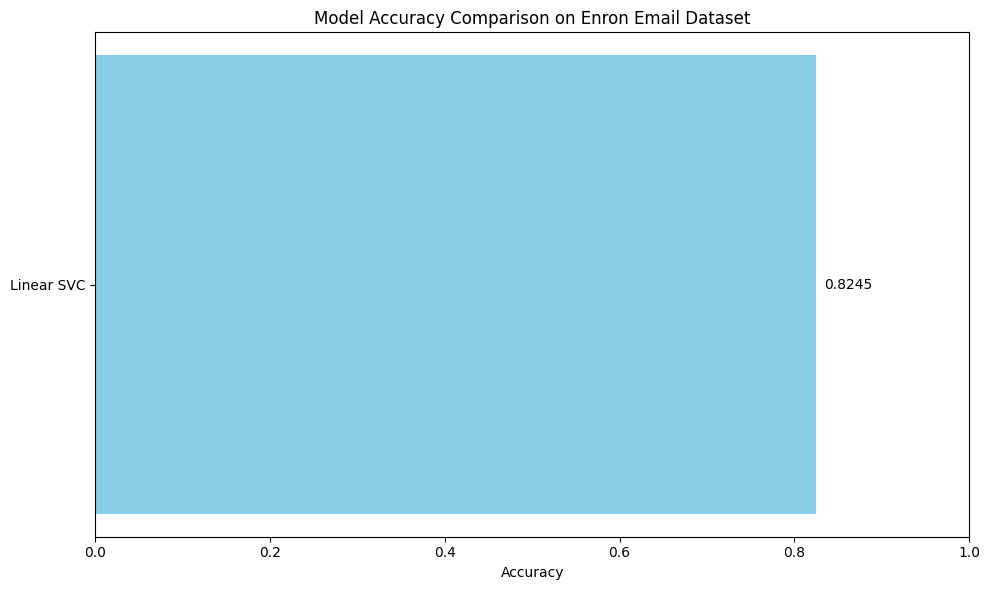

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(results_df["Model"], results_df["Accuracy"], color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison on Enron Email Dataset")
plt.xlim(0, 1.0)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.4f}', va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
accuracies = []
c_values = np.arange(0.1, 1.8, 0.1)
for c in c_values: 
    model = LinearSVC(C=c, max_iter=10000, dual=False)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    print(f"C={c:.1f} → Accuracy: {acc:.4f}")

C=0.1 → Accuracy: 0.8095
C=0.2 → Accuracy: 0.8210
C=0.3 → Accuracy: 0.8233
C=0.4 → Accuracy: 0.8245


KeyboardInterrupt: 

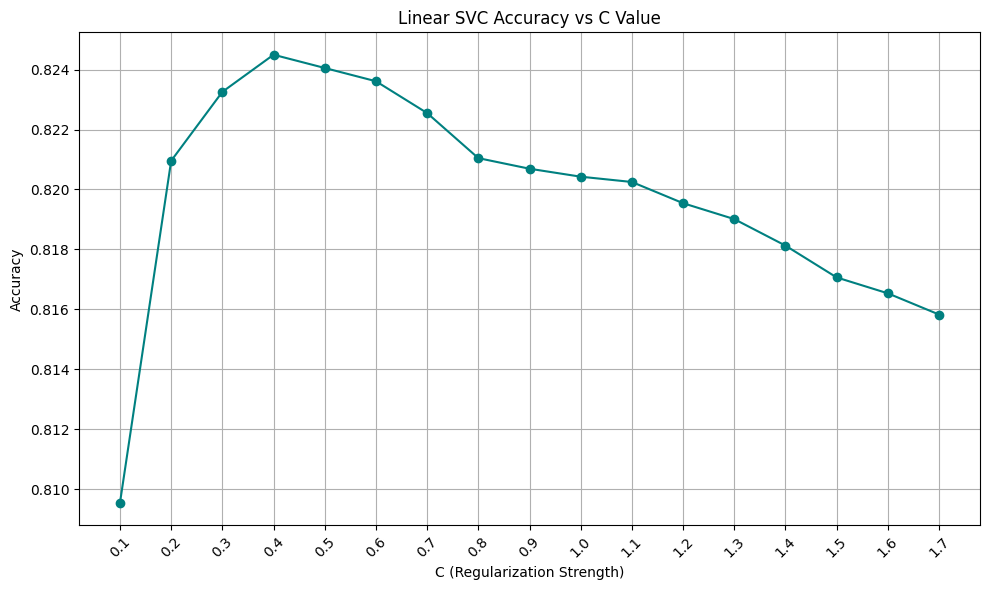

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(c_values, accuracies, marker='o', color='teal')
plt.title('Linear SVC Accuracy vs C Value')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(c_values, rotation=45)
plt.tight_layout()
plt.show()

In [19]:
accuracies = []
alphas = np.arange(0.1, 1.8, 0.1)
for alpha in alphas:
    model = RidgeClassifier(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Alpha: {alpha:.2f} → Accuracy: {acc:.4f}")

Alpha: 0.10 → Accuracy: 0.8059
Alpha: 0.20 → Accuracy: 0.8118
Alpha: 0.30 → Accuracy: 0.8149
Alpha: 0.40 → Accuracy: 0.8172
Alpha: 0.50 → Accuracy: 0.8181
Alpha: 0.60 → Accuracy: 0.8189
Alpha: 0.70 → Accuracy: 0.8188
Alpha: 0.80 → Accuracy: 0.8190
Alpha: 0.90 → Accuracy: 0.8189
Alpha: 1.00 → Accuracy: 0.8187
Alpha: 1.10 → Accuracy: 0.8191
Alpha: 1.20 → Accuracy: 0.8190
Alpha: 1.30 → Accuracy: 0.8195
Alpha: 1.40 → Accuracy: 0.8195
Alpha: 1.50 → Accuracy: 0.8195
Alpha: 1.60 → Accuracy: 0.8187
Alpha: 1.70 → Accuracy: 0.8179


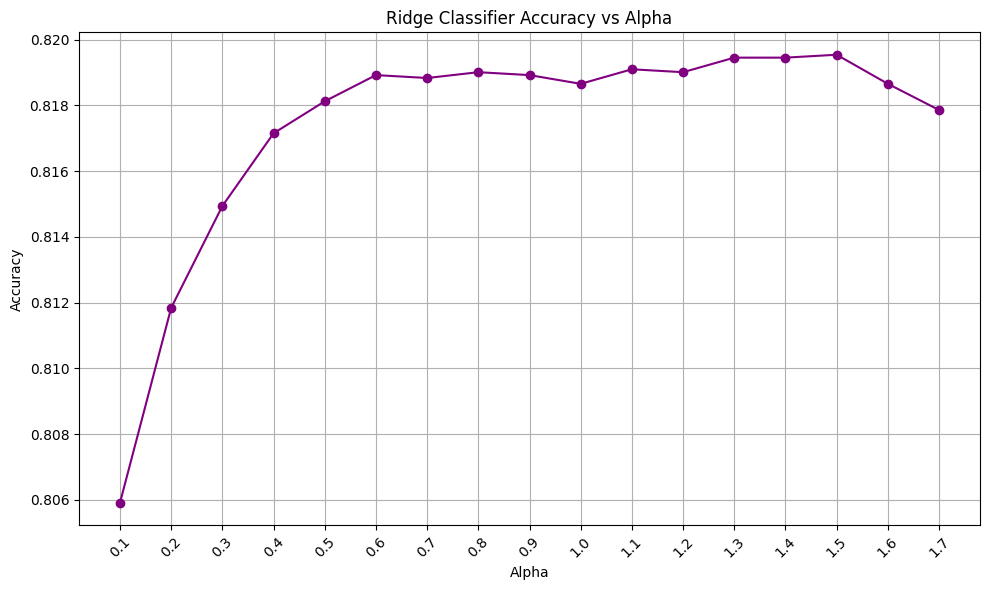

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, accuracies, marker='o', linestyle='-', color='purple')
plt.title('Ridge Classifier Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(alphas, rotation=45)
plt.tight_layout()
plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels_filt)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class DeeperNet(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(DeeperNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout = nn.Dropout(0.4)
        self.output = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        return self.output(x)

# Use correct input_dim
input_dim = X_train_tensor.shape[1]
model = DeeperNet(input_dim=input_dim, hidden_dim1=2048, hidden_dim2=1024, output_dim=len(le.classes_))

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Training loop
train_accuracies = []
test_accuracies = []
train_losses = []
num_epochs=200
for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Track training loss and accuracy
    train_losses.append(loss.item())
    _, predicted_train = torch.max(outputs, 1)
    correct_train = (predicted_train == y_train_tensor).sum().item()
    train_acc = correct_train / len(y_train_tensor)
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        _, predicted_test = torch.max(outputs_test, 1)
        correct_test = (predicted_test == y_test_tensor).sum().item()
        test_acc = correct_test / len(y_test_tensor)
        test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1, Loss: 5.0681, Train Acc: 0.0053, Test Acc: 0.0355
Epoch 2, Loss: 4.4621, Train Acc: 0.1126, Test Acc: 0.0358


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='s', label="Test Accuracy")
plt.plot(range(1, num_epochs + 1), train_losses, marker='d', label="Train Loss")
plt.title("Training vs. Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
models = {}

#modelsButPair =[()]
scores=[]

for i in range(1,100):
    kNumber= "k nearest neighbors k=" + str(i)
    models[kNumber]=KNeighborsClassifier(metric='cosine',n_neighbors=i)
    
    #modelsButPair[i-1]=zip(i,KNeighborsClassifier(n_neighbors=i))
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    print("fitted")
    preds = model.predict(X_test)
    score=accuracy_score(y_test, preds)
    scores.append(score)
    print(score)
    #print(classification_report(y_test, preds))


k nearest neighbors k=1
fitted
0.6296132401097442

k nearest neighbors k=2
fitted
0.5874856181963005

k nearest neighbors k=3
fitted


KeyboardInterrupt: 

In [ ]:
k_values=list(range(1,100))
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o')
plt.title('Accuracy of k-NN Model for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(0, 101, 2))
plt.tight_layout()
plt.show()